# Analyse des données

In [26]:
import pandas as pd
import matplotlib.pyplot as plt


# Charger le fichier JSON
df = pd.read_json("Data.json", lines=True)

# Afficher les 5 premières lignes
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [30]:
# Afficher les colonnes disponibles
print(df.columns)

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')


In [28]:
# Informations générales sur le dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10234 non-null  object
 3   helpful         10261 non-null  object
 4   reviewText      10261 non-null  object
 5   overall         10261 non-null  int64 
 6   summary         10261 non-null  object
 7   unixReviewTime  10261 non-null  int64 
 8   reviewTime      10261 non-null  object
dtypes: int64(2), object(7)
memory usage: 721.6+ KB
None


In [29]:
# Quelques statistiques de base sur les colonnes numériques
print(df.describe())

            overall  unixReviewTime
count  10261.000000    1.026100e+04
mean       4.488744    1.360606e+09
std        0.894642    3.779735e+07
min        1.000000    1.095466e+09
25%        4.000000    1.343434e+09
50%        5.000000    1.368490e+09
75%        5.000000    1.388966e+09
max        5.000000    1.405987e+09


### Déséquilibre des classes dans les avis

La grande majorité des avis sont positifs, avec une note de 4 ou 5.

Ce déséquilibre peut poser un problème dans le cadre d’une classification multiclasse (positif, neutre, négatif), car les avis négatifs et neutres sont sous-représentés.

Il pourrait donc être pertinent d’envisager un équilibrage des classes, en appliquant par exemple des techniques de sous-échantillonnage de la classe majoritaire ou de sur-échantillonnage (comme SMOTE) pour les classes minoritaires, afin d’améliorer les performances du modèle de prédiction.

In [31]:
print(df.isnull().sum())

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64


Nous avons vérifié les colonnes essentielles suivantes : `reviewText`, `overall` et `summary`. Aucune valeur manquante n’a été détectée pour ces champs, ce qui garantit l’intégrité des données nécessaires à l’analyse.  
Concernant la colonne `reviewerName`, bien qu’elle contienne quelques valeurs manquantes, nous avons décidé de les ignorer, car cette information n’est pas critique pour notre étude.

In [32]:
# Exclure la colonne 'helpful' pour détecter les doublons
df_no_helpful = df.drop(columns=['helpful'])
print(df_no_helpful.duplicated().sum())

0


il y a pas des doublons

In [33]:
print(df["overall"].value_counts().sort_index())

overall
1     217
2     250
3     772
4    2084
5    6938
Name: count, dtype: int64


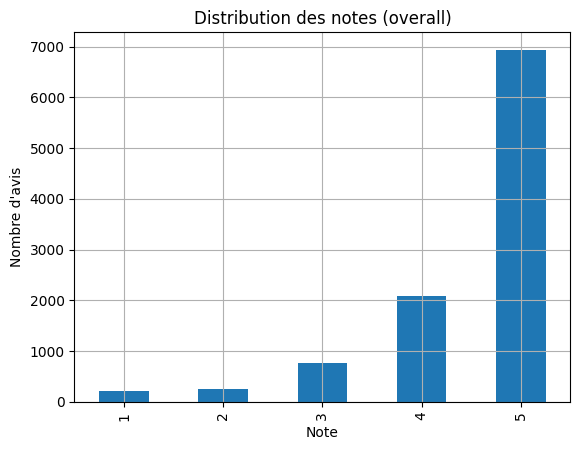

In [34]:
df["overall"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution des notes (overall)")
plt.xlabel("Note")
plt.ylabel("Nombre d'avis")
plt.grid(True)
plt.show()

### Déséquilibre important des classes

Les données présentent un fort déséquilibre :

- Plus de **87 %** des avis sont **positifs** (note 4 ou 5).
- Moins de **5 %** sont **négatifs** (note 1 ou 2).

Ce déséquilibre peut **biaisser l’entraînement du modèle**, qui risque de **prédire la classe « positif » de manière excessive**, au détriment des classes minoritaires.  
Il est donc essentiel de prendre ce phénomène en compte, notamment par des techniques d’équilibrage ou des métriques d’évaluation adaptées.

In [35]:
df["text_length"] = df["reviewText"].apply(lambda x: len(str(x)))
print(df["text_length"].describe())

count    10261.000000
mean       485.929052
std        613.436113
min          0.000000
25%        162.000000
50%        284.000000
75%        552.000000
max      11310.000000
Name: text_length, dtype: float64


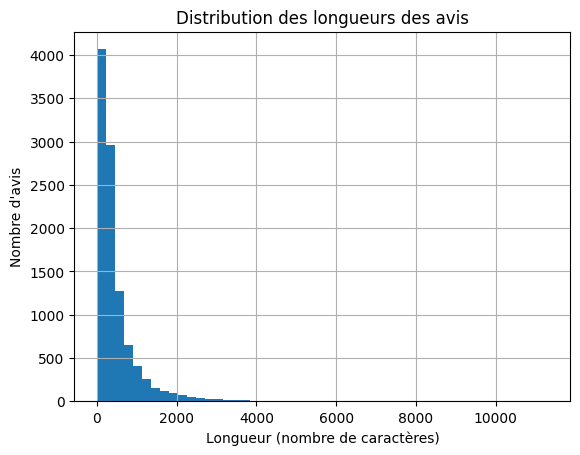

In [36]:
df["text_length"].hist(bins=50)
plt.title("Distribution des longueurs des avis")
plt.xlabel("Longueur (nombre de caractères)")
plt.ylabel("Nombre d'avis")
plt.show()

### Analyse de la longueur des avis

- La majorité des avis ont une longueur **courte à moyenne**, comprise entre **162 et 552 caractères**.
- Quelques avis sont **très longs** (jusqu’à **11 000 caractères**), ce qui peut **augmenter les temps de traitement** lors de l'entraînement du modèle.
- Certains avis sont **vides** (longueur = 0) : ces lignes doivent être **supprimées**, car elles sont **inutiles pour l’analyse et l'apprentissage automatique**.

In [37]:
# Supprimer les lignes où le texte est vide
df = df[df['text_length'] > 0]

In [38]:
# Conversion du timestamp Unix en date lisible
df["reviewTime"] = pd.to_datetime(df["unixReviewTime"], unit='s')

# Extraire l'année
df["reviewYear"] = df["reviewTime"].dt.year

# Compter les avis par année
print(df["reviewYear"].value_counts().sort_index())

reviewYear
2004       7
2005       4
2006      10
2007      22
2008      63
2009     127
2010     350
2011    1006
2012    1933
2013    4053
2014    2679
Name: count, dtype: int64


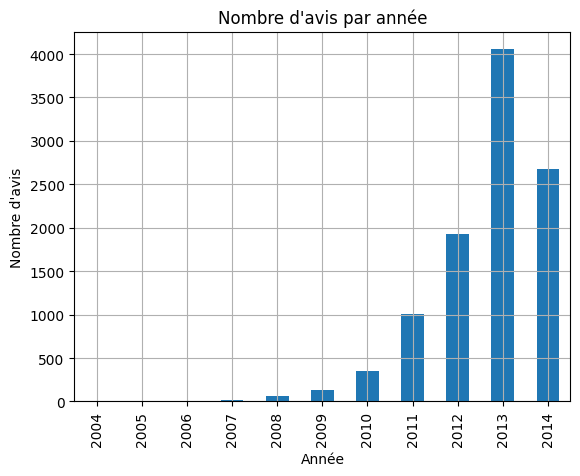

In [39]:
df["reviewYear"].value_counts().sort_index().plot(kind="bar")
plt.title("Nombre d'avis par année")
plt.xlabel("Année")
plt.ylabel("Nombre d'avis")
plt.grid(True)
plt.show()

### Répartition des avis par année

L’analyse temporelle montre que la majorité des avis sont concentrés entre **2011 et 2014**, avec un **pic significatif en 2013**. Cette année seule représente **plus de 4 000 avis**, soit **environ 40 %** du jeu de données, ce qui en fait une année dominante.

En revanche, les années antérieures (de **2004 à 2010**) contiennent **très peu d’évaluations**, les rendant **statistiquement peu représentatives**.

Ainsi, il peut être pertinent d’**exclure ces années** dans certaines analyses, afin de travailler sur un **échantillon plus homogène et pertinent**.

In [40]:
def create_label(row):
    if row['overall'] < 3:
        return 0  # négatif
    elif row['overall'] == 3:
        return 1  # neutre
    else:
        return 2  # positif

df['label'] = df.apply(create_label, axis=1)

In [42]:
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split()))

In [43]:
df.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,text_length,reviewYear,label,word_count
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,2014-02-28,268,2014,2,51


        count        mean         std   min    25%    50%    75%      max
label                                                                    
0       467.0  579.205567  672.310315  32.0  224.0  375.0  682.0   7180.0
1       772.0  579.211140  772.882466  24.0  172.0  351.5  642.5  10275.0
2      9015.0  473.486190  593.570029   9.0  160.0  275.0  538.0  11310.0


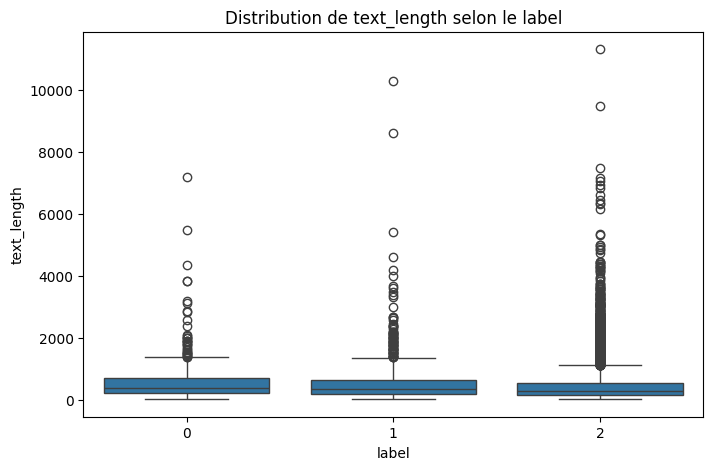

In [44]:
# Statistiques descriptives
print(df.groupby('label')['text_length'].describe())

# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Distribution de text_length selon le label')
plt.show()

        count        mean         std  min   25%   50%    75%     max
label                                                                
0       467.0  107.531049  121.711721  7.0  42.0  70.0  127.5  1290.0
1       772.0  107.773316  138.667100  5.0  33.0  67.0  122.0  1760.0
2      9015.0   87.848364  107.794190  1.0  30.0  52.0  101.0  2043.0


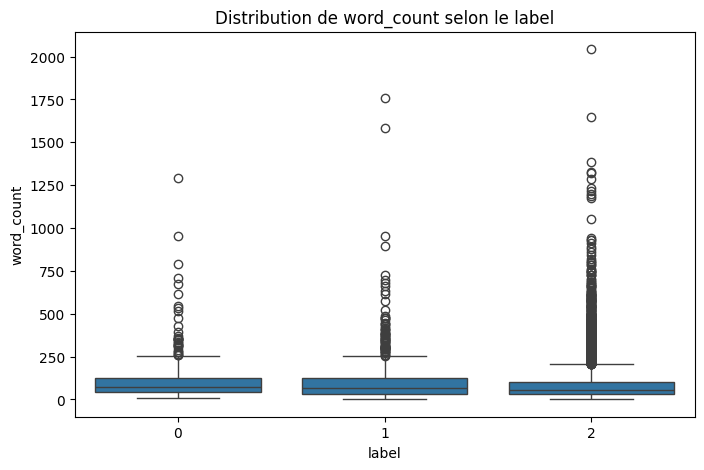

In [45]:
# Statistiques descriptives
print(df.groupby('label')['word_count'].describe())

# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='word_count', data=df)
plt.title('Distribution de word_count selon le label')
plt.show()

###  Synthèse générale des longueurs de texte

- Les **avis positifs** ont tendance à être **plus courts**, avec **moins de mots** et **moins de caractères**.
- Les **avis négatifs** et **neutres** sont généralement **plus longs** et **plus détaillés** (plus de mots, plus de caractères).
- La **dispersion** (écart-type) est **élevée** pour tous les types d’avis, ce qui indique une **grande variabilité** dans la longueur des textes.

---

###  Pourquoi `word_count` et `text_length` sont-ils importants pour l’entraînement du modèle ?

####  Informations supplémentaires
Ces deux colonnes fournissent des **informations quantitatives** sur la **longueur** et la **richesse** des avis. Cela peut influencer la **nature** et la **polarité** du texte.

####  Caractéristiques discriminantes
On observe que la **longueur moyenne** et le **nombre de mots** diffèrent selon le **type d’avis** (positif, neutre, négatif). Ces variables peuvent donc aider le modèle à **mieux distinguer les classes**.

####  Amélioration de la performance
L’ajout de ces features offre au modèle un **contexte supplémentaire**, surtout si certains textes sont très courts ou très variables. Cela peut **renforcer la robustesse** du modèle.

####  Gestion des biais
Les avis **très courts** ou **très longs** peuvent induire des biais. En intégrant leur longueur, le modèle est **mieux équipé** pour traiter ces cas et **réduire les erreurs** dues uniquement au contenu textuel.

---

 **Conclusion** : `word_count` et `text_length` sont des **features simples mais puissantes**, qui complètent efficacement le traitement du texte brut et **améliorent les performances globales du modèle**.

# Mini Projet Big Data 2024-2025: Analyse des avis clients Amazon en temps réel

## 1. Configuration initiale

### 1.1 Importation des bibliothèques

In [2]:
# Importation des bibliothèques nécessaires
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
from pyspark.ml.feature import StringIndexerModel
warnings.filterwarnings('ignore')

# Import des bibliothèques PySpark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when, lit, rand, length, size, split
from pyspark.sql.types import StringType, FloatType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

### 1.2 Téléchargement des ressources NLTK

*NLTK nécessite le téléchargement de certaines ressources linguistiques pour fonctionner correctement. Cette cellule s'en charge.*

In [3]:
# Téléchargement des ressources NLTK nécessaires
def download_nltk_resources():
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('punkt_tab')

### 1.3 Initialisation de Spark

*Configuration de la session Spark avec des paramètres mémoire adaptés au traitement des données volumineuses.*

In [4]:
def initialize_spark():
    """Initialisation de la session Spark avec plus de mémoire"""
    spark = SparkSession.builder \
        .appName("AmazonReviewsSentimentAnalysis") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .getOrCreate()
    print("Spark version:", spark.version)
    return spark

## 2. Chargement et exploration des données

### 2.1 Chargement des données

*Les données sont chargées depuis un fichier JSON contenant les avis Amazon.*

In [5]:
def load_data(file_path):
    """Chargement des données depuis un fichier JSON"""
    print("Chargement des données...")
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    df = pd.DataFrame(data)
    print("Aperçu des données:")
    print(df.head())
    return df

### 2.2 Prétraitement initial

Cette étape prépare les données en :
- Sélectionnant les colonnes pertinentes
- Fusionnant les textes d'avis et résumés
- Créant la variable cible 'sentiment'
- Calculant des métriques de longueur

In [6]:
def preprocess_dataframe(df):
    """Prétraitement des données pour garder uniquement les colonnes nécessaires"""
    print("\nPrétraitement des données...")

    # Conserver uniquement les colonnes nécessaires
    columns_to_keep = ['reviewText', 'summary', 'overall']
    df_processed = df[columns_to_keep].copy()

    # Création de la colonne 'reviews' = reviewText + summary
    df_processed['reviews'] = df_processed['reviewText'] + ' ' + df_processed['summary']

    # Suppression des colonnes désormais inutiles
    df_processed = df_processed.drop(['reviewText', 'summary'], axis=1)

    # Création de la colonne cible 'sentiment' selon la règle donnée
    df_processed['sentiment'] = df_processed['overall'].apply(lambda x: 'Negative' if x < 3 else ('Neutral' if x == 3 else 'Positive'))

    # Calcul de la longueur de l'avis et du nombre de mots
    df_processed['review_len'] = df_processed['reviews'].astype(str).apply(len)
    df_processed['word_count'] = df_processed['reviews'].apply(lambda x: len(str(x).split()))

    # Supprimer la colonne overall après avoir créé sentiment
    df_processed = df_processed.drop('overall', axis=1)

    return df_processed

## 3. Nettoyage et préparation du texte

### 3.1 Nettoyage de base

Suppression des :
- URLs
- Caractères spéciaux
- Chiffres
- Espaces multiples
Conversion en minuscules

In [7]:
def clean_text(text):
    """Nettoyer le texte des avis"""
    # Conversion en minuscules
    text = text.lower()
    # Suppression des URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Suppression des caractères spéciaux et chiffres
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
def apply_text_preprocessing(df):
    """Appliquer le prétraitement de texte au DataFrame"""
    print("\nApplication du prétraitement de texte...")

    # Application du nettoyage de texte
    df['cleaned_reviews'] = df['reviews'].apply(clean_text)

    # Application du prétraitement de texte
    df['processed_reviews'] = df['cleaned_reviews'].apply(preprocess_text)

    return df

### 3.2 Prétraitement avancé

In [9]:
def preprocess_text(text):
    """Tokenisation et suppression des stopwords"""
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

## 4. Analyse exploratoire

### 4.1 Visualisation des données

Cette section génère des graphiques pour :
- La distribution des sentiments
- La longueur des avis
- Le nombre de mots

In [11]:
def visualize_data(df):
    """Visualisation des données"""
    print("\nVisualisation des données...")

    # Distribution des sentiments
    print("\nDistribution des sentiments:")
    sentiment_count = df['sentiment'].value_counts()
    print(sentiment_count)

    # Visualisation de la distribution des sentiments
    plt.figure(figsize=(10, 6))
    sns.countplot(x='sentiment', data=df, palette='viridis')
    plt.title('Distribution des Sentiments')
    plt.ylabel('Nombre d\'avis')
    plt.savefig('sentiment_distribution.png')
    plt.close()

    # Visualisation des distributions de longueur
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df['review_len'], kde=True)
    plt.title('Distribution de la longueur des avis')

    plt.subplot(1, 2, 2)
    sns.histplot(df['word_count'], kde=True)
    plt.title('Distribution du nombre de mots')

    plt.tight_layout()
    plt.savefig('distributions.png')
    plt.close()

## 5. Préparation pour le machine learning

### 5.1 Conversion en DataFrame Spark

*Adaptation des données pour le traitement distribué avec PySpark.*

In [13]:
def convert_to_spark_df(spark, df):
    """Conversion en DataFrame Spark"""
    print("\nConversion des données en DataFrame Spark...")
    spark_df = spark.createDataFrame(df)
    print("\nAperçu du DataFrame Spark:")
    spark_df.show(5, truncate=False)
    return spark_df

### 5.2 Division des données

In [14]:
def split_data(spark_df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """Division des données en ensembles d'entraînement, validation et test"""
    print("\nDivision des données...")

    assert train_ratio + val_ratio + test_ratio == 1.0, "Les ratios doivent sommer à 1"

    # 80% entraînement, 20% temporaire
    train_spark_df, temp_df = spark_df.randomSplit([train_ratio, val_ratio + test_ratio], seed=42)

    # Division du temporaire en validation et test
    val_spark_df, test_spark_df = temp_df.randomSplit([val_ratio / (val_ratio + test_ratio),
                                                      test_ratio / (val_ratio + test_ratio)], seed=42)

    print(f"Taille de l'ensemble d'entraînement: {train_spark_df.count()}")
    print(f"Taille de l'ensemble de validation: {val_spark_df.count()}")
    print(f"Taille de l'ensemble de test: {test_spark_df.count()}")

    return train_spark_df, val_spark_df, test_spark_df

### 5.3 Équilibrage des classes

*Sur-échantillonnage des classes minoritaires pour éviter les biais dans l'apprentissage.*

In [15]:
def balance_classes(train_spark_df):
    """Équilibrage des classes par sur-échantillonnage"""
    print("\nÉquilibrage des classes par sur-échantillonnage...")

    # Compter les occurrences de chaque classe
    class_counts = train_spark_df.groupBy("sentiment").count().collect()
    class_counts_dict = {row["sentiment"]: row["count"] for row in class_counts}

    # Identifier la classe majoritaire
    majority_class = max(class_counts_dict.items(), key=lambda x: x[1])[0]
    majority_count = class_counts_dict[majority_class]

    print(f"Classe majoritaire: {majority_class} avec {majority_count} observations")

    # Sur-échantilloner les classes minoritaires
    balanced_dfs = []
    for sentiment in class_counts_dict.keys():
        class_df = train_spark_df.filter(col("sentiment") == sentiment)

        if sentiment != majority_class:
            # Calculer le ratio pour atteindre l'équilibre avec la classe majoritaire
            ratio = float(majority_count) / float(class_counts_dict[sentiment])
            # Arrondir au nombre entier supérieur
            num_repeats = int(np.ceil(ratio))

            # Sur-échantillonnage par réplication
            oversampled_df = class_df
            for _ in range(num_repeats - 1):
                oversampled_df = oversampled_df.union(class_df)

            # Limiter au nombre exact dont nous avons besoin
            oversampled_df = oversampled_df.limit(majority_count)
            balanced_dfs.append(oversampled_df)

            print(f"Classe {sentiment}: {class_counts_dict[sentiment]} → {oversampled_df.count()} observations après sur-échantillonnage")
        else:
            balanced_dfs.append(class_df)
            print(f"Classe {sentiment}: {class_counts_dict[sentiment]} observations (inchangée)")

    # Combiner tous les DataFrames équilibrés
    balanced_train_df = balanced_dfs[0]
    for df in balanced_dfs[1:]:
        balanced_train_df = balanced_train_df.union(df)

    # Mélanger les données équilibrées
    balanced_train_df = balanced_train_df.orderBy(rand())

    print(f"Ensemble d'entraînement après équilibrage: {balanced_train_df.count()} observations")

    # Vérifier la distribution après équilibrage
    print("\nDistribution des classes après équilibrage:")
    balanced_class_counts = balanced_train_df.groupBy("sentiment").count().collect()
    for row in balanced_class_counts:
        print(f"{row['sentiment']}: {row['count']}")

    # Création d'une colonne de poids pour les modèles
    balanced_train_df = balanced_train_df.withColumn("weight", lit(1.0))

    return balanced_train_df

## 6. Construction des modèles

### 6.1 Pipeline de features

Création des transformations pour :
- Tokenisation
- Suppression des stopwords
- Vectorisation (TF-IDF)
- Encodage des labels

In [16]:
def create_feature_pipeline():
    """Création de la pipeline de traitement des caractéristiques"""
    # Tokenisation
    tokenizer = Tokenizer(inputCol="processed_reviews", outputCol="words")

    # Suppression des stopwords
    stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

    # Vectorisation
    count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features", maxDF=0.8, minDF=3.0)

    # TF-IDF
    idf = IDF(inputCol="raw_features", outputCol="features")

    # Encodage de la cible
    string_indexer = StringIndexer(inputCol="sentiment", outputCol="label")

    # Assembler toutes les caractéristiques
    assembler = VectorAssembler(
        inputCols=["features", "review_len", "word_count"],
        outputCol="all_features"
    )

    return [tokenizer, stopwords_remover, count_vectorizer, idf, string_indexer, assembler]

### 6.2 Définition des modèles

Initialisation de trois algorithmes :
- Régression logistique
- Arbre de décision
- Forêt aléatoire

In [17]:
def create_model_pipelines(feature_pipeline):
    """Création des pipelines de modèles"""
    # Définition des modèles
    lr = LogisticRegression(maxIter=100, regParam=0.1, elasticNetParam=0.0, featuresCol="all_features", weightCol="weight")
    dt = DecisionTreeClassifier(maxDepth=10, featuresCol="all_features", weightCol="weight")
    rf = RandomForestClassifier(numTrees=100, maxDepth=10, featuresCol="all_features", weightCol="weight")

    # Création des pipelines
    lr_pipeline = Pipeline(stages=feature_pipeline + [lr])
    dt_pipeline = Pipeline(stages=feature_pipeline + [dt])
    rf_pipeline = Pipeline(stages=feature_pipeline + [rf])

    return {
        "Logistic Regression": lr_pipeline,
        "Decision Tree": dt_pipeline,
        "Random Forest": rf_pipeline
    }

## 7. Entraînement et évaluation

### 7.1 Entraînement et Evaluatuion Pour Un Seul Modèle

Cette fonction effectue l’entraînement et l’évaluation d’un modèle de classification **Spark MLlib** à l’aide d’un pipeline donné.  
Elle prend en entrée :

- un **pipeline** (`Pipeline`),
- un **nom de modèle** (chaîne de caractères),
- trois jeux de données : `train_data`, `val_data`, `test_data`.

📌 Étapes réalisées :

1. **Entraînement** du modèle sur les données d'entraînement (`train_data`).
2. **Évaluation sur le jeu de validation** pour mesurer la performance initiale.
3. **Évaluation finale sur le jeu de test**, avec calcul des éléments suivants :
   - ✅ **Précision globale** (accuracy),
   - 📊 **Matrice de confusion** affichée sous forme de **tableau** et de **heatmap**,
   - 🔍 **Métriques par classe** : précision, rappel, F1-score,
   - 📈 **Métriques globales pondérées** : `weightedPrecision`, `weightedRecall`, `f1`.
4. 📁 **Visualisation et sauvegarde** de la matrice de confusion sous forme d'image `.png`.

Cette fonction permet de comparer plusieurs modèles de manière systématique, claire et visuelle.

In [18]:
def train_and_evaluate_model(pipeline, name, train_data, val_data, test_data):
    """Entraînement et évaluation d'un modèle avec métriques détaillées"""
    print(f"\nEntraînement du modèle {name}...")

    evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    )

    # Entraînement du modèle
    model = pipeline.fit(train_data)

    # Évaluation sur la validation
    val_predictions = model.transform(val_data)
    val_accuracy = evaluator.evaluate(val_predictions)
    print(f"{name} - Validation Accuracy: {val_accuracy:.4f}")

    # Évaluation sur le test
    test_predictions = model.transform(test_data)
    test_accuracy = evaluator.evaluate(test_predictions)
    print(f"{name} - Test Accuracy: {test_accuracy:.4f}")

    # Récupération des labels
    string_indexer = [stage for stage in model.stages if isinstance(stage, StringIndexerModel)][0]
    labels = string_indexer.labels

    # Matrice de confusion
    test_results = test_predictions.select("label", "prediction").toPandas()
    conf_matrix = pd.crosstab(
        test_results['label'],
        test_results['prediction'],
        rownames=['Réel'],
        colnames=['Prédit']
    )

    # Affichage dans le terminal
    print(f"\nMatrice de confusion ({name}):")
    print(conf_matrix)

    # Visualisation et sauvegarde
    plt.figure(figsize=(10,7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Matrice de confusion - {name}')
    plt.savefig(f'confusion_matrix_{name}.png')
    plt.close()

    # Calcul des métriques par classe
    print(f"\nMétriques détaillées ({name}):")
    for i, label in enumerate(labels):
        tp = conf_matrix.loc[i,i]
        fp = conf_matrix[i].sum() - tp
        fn = conf_matrix.loc[i].sum() - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"Classe {label}:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Rappel:    {recall:.4f}")
        print(f"  F1-score:  {f1:.4f}\n")

    # Métriques globales
    evaluator.setMetricName("weightedPrecision")
    precision = evaluator.evaluate(test_predictions)
    evaluator.setMetricName("weightedRecall")
    recall = evaluator.evaluate(test_predictions)
    evaluator.setMetricName("f1")
    f1 = evaluator.evaluate(test_predictions)

    print(f"Métriques globales:")
    print(f"  Precision moyenne: {precision:.4f}")
    print(f"  Rappel moyen:     {recall:.4f}")
    print(f"  F1-score moyen:   {f1:.4f}")

    return val_accuracy, model

### 7.2 Entraînement et Evaluatuion Pour Tous Les Modèles

In [19]:
def train_all_models(model_pipelines, balanced_train_df, val_spark_df, test_spark_df):
    """Entraînement et évaluation de tous les modèles"""
    print("\n====== Entraînement et évaluation des modèles PySpark ======")

    # Dictionnaire pour stocker les résultats
    model_results = {}

    # Entraînement et évaluation des modèles
    for name, pipeline in model_pipelines.items():
        model_results[name] = train_and_evaluate_model(pipeline, name, balanced_train_df, val_spark_df, test_spark_df)

    # Sélection du meilleur modèle
    best_model_name = max(model_results.items(), key=lambda x: x[1][0])[0]
    best_accuracy, best_model = model_results[best_model_name]

    print(f"\nMeilleur modèle PySpark: {best_model_name} avec une précision de {best_accuracy:.4f}")

    return best_model_name, best_model

## 8. Déploiement

### 8.1 Sauvegarde du meilleur modèle

*Conservation du modèle ayant obtenu les meilleures performances pour une utilisation future.*

In [20]:
def save_model(model, path):
    """Sauvegarde du modèle"""
    print("\n====== Sauvegarde du meilleur modèle ======")
    model.save(path)
    print(f"Meilleur modèle sauvegardé avec succès à {path}!")

### 8.2 Fonction de prédiction

*Création d'une fonction capable de prédire le sentiment sur de nouveaux textes.*

In [21]:
def create_prediction_function(spark, model):
    """Création d'une fonction de prédiction pour de nouvelles données"""
    # Importation des fonctions nécessaires pour la prédiction
    from pyspark.sql.functions import length, size, split, col, lit

    # Définition des UDFs pour les fonctions de nettoyage
    clean_text_udf = udf(clean_text, StringType())
    preprocess_text_udf = udf(preprocess_text, StringType())

    def predict_sentiment(text):
        # Création d'un DataFrame avec une seule ligne
        data = [(text,)]
        schema = ["text"]
        test_df = spark.createDataFrame(data, schema)

        # Application des mêmes transformations que dans le pipeline
        test_df = test_df.withColumn("reviews", col("text"))
        test_df = test_df.withColumn("cleaned_reviews", clean_text_udf("reviews"))
        test_df = test_df.withColumn("processed_reviews", preprocess_text_udf("cleaned_reviews"))

        # Calcul des caractéristiques nécessaires
        test_df = test_df.withColumn("review_len", length(col("reviews")))
        test_df = test_df.withColumn("word_count", size(split(col("reviews"), " ")))

        # Ajout de la colonne de poids
        test_df = test_df.withColumn("weight", lit(1.0))

        # Prédiction
        prediction = model.transform(test_df)
        result = prediction.select("prediction").collect()[0][0]

        # Conversion de la prédiction numérique en étiquette
        sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
        return sentiment_labels[result]

    return predict_sentiment

## 9. Démonstration

Cette fonction permet de **tester le modèle de prédiction de sentiment** sur des exemples concrets appartenant à **chaque classe possible** (positif, neutre, négatif).  
Elle est utile pour évaluer rapidement et visuellement la **cohérence des prédictions du modèle sur des phrases courantes**.

 📌 Contenu de la fonction :

- Création de **3 exemples** pour **chaque classe** :
  -  **Exemples positifs** : commentaires enthousiastes ou très satisfaits.
  -  **Exemples neutres** : commentaires modérés ou mitigés.
  -  **Exemples négatifs** : commentaires critiques ou très insatisfaits.

- Chaque exemple est passé à la fonction `predict_sentiment`, qui retourne la prédiction du modèle (ex. : `positive`, `neutral`, `negative`).

- Les résultats sont affichés dans la console, ce qui permet une vérification rapide de la performance du modèle sur des cas typiques.

In [22]:
def test_examples(predict_sentiment):
    """Test avec des exemples de différentes classes"""
    print("\n====== Test avec des exemples de différentes classes ======")

    # Exemples positifs
    positive_examples = [
        "This product is absolutely amazing! I love it so much.",
        "Best purchase I've made this year, highly recommended!",
        "The quality exceeded my expectations, worth every penny."
    ]

    # Exemples neutres
    neutral_examples = [
        "The product is okay, nothing special but gets the job done.",
        "It's fine, I expected more for the price but it's acceptable.",
        "Not bad, not great - just average."
    ]

    # Exemples négatifs
    negative_examples = [
        "Terrible product, broke after just one use!",
        "Waste of money, completely disappointed with this purchase.",
        "The worst quality I've ever seen, do not recommend."
    ]

    # Test des exemples
    print("\nPrédictions pour les exemples positifs:")
    for example in positive_examples:
        print(f"'{example[:50]}...' → {predict_sentiment(example)}")

    print("\nPrédictions pour les exemples neutres:")
    for example in neutral_examples:
        print(f"'{example[:50]}...' → {predict_sentiment(example)}")

    print("\nPrédictions pour les exemples négatifs:")
    for example in negative_examples:
        print(f"'{example[:50]}...' → {predict_sentiment(example)}")

## 10.Main

La fonction `main()` constitue le **point d'entrée principal du script**.  
Elle orchestre l'ensemble des étapes du pipeline de traitement et de classification des sentiments à partir d'un fichier JSON contenant des avis clients.

📌 Étapes réalisées :

1. 📥 **Téléchargement des ressources NLTK** nécessaires pour le nettoyage de texte (`stopwords`, `punkt`, etc.).
2. 🔧 **Initialisation de la session Spark**, moteur de traitement distribué utilisé pour la scalabilité.
3. 📂 **Chargement des données** à partir d’un fichier JSON (`/content/Data.json`).
4. 🧹 **Prétraitement initial** des données (suppression des valeurs manquantes, formatage).
5. ✍️ **Nettoyage des textes** (tokenisation, suppression des stopwords, etc.).
6. 📊 **Visualisation exploratoire** pour mieux comprendre la répartition des sentiments.
7. 🔄 **Conversion vers un DataFrame Spark** pour traitement distribué.
8. ✂️ **Découpage des données** en ensembles d'entraînement, de validation et de test.
9. ⚖️ **Équilibrage des classes** pour éviter les biais lors de l'entraînement.
10. 🏗️ **Création du pipeline de traitement de texte** (TF-IDF, vectorisation...).
11. 🤖 **Création de plusieurs pipelines de modèles** de classification (ex : Logistic Regression, Random Forest...).
12. 🧪 **Entraînement et évaluation de tous les modèles** sur les jeux de validation et de test.
13. 💾 **Sauvegarde du meilleur modèle entraîné** sur le disque.
14. 🧠 **Création d’une fonction de prédiction** permettant d’inférer le sentiment d’un texte libre.
15. 🧪 **Tests du modèle** sur des exemples réels (positifs, neutres, négatifs).
16. 🛑 **Fermeture propre de la session Spark** une fois le script terminé.

> Cette fonction coordonne **l'ensemble du flux de traitement de données à la prédiction finale**, assurant un pipeline complet, automatisé et reproductible.

In [23]:
def main():
    """Fonction principale"""
    # Téléchargement des ressources NLTK
    download_nltk_resources()

    # Initialisation de la session Spark
    spark = initialize_spark()

    try:
        # Chargement des données
        df = load_data('/content/Data.json')

        # Prétraitement des données
        df_processed = preprocess_dataframe(df)

        # Application du prétraitement de texte
        df_processed = apply_text_preprocessing(df_processed)

        # Visualisation des données
        visualize_data(df_processed)

        # Conversion en DataFrame Spark
        spark_df = convert_to_spark_df(spark, df_processed)

        # Division des données
        train_spark_df, val_spark_df, test_spark_df = split_data(spark_df)

        # Équilibrage des classes
        balanced_train_df = balance_classes(train_spark_df)

        # Création de la pipeline de traitement des caractéristiques
        feature_pipeline = create_feature_pipeline()

        # Création des pipelines de modèles
        model_pipelines = create_model_pipelines(feature_pipeline)

        # Entraînement et évaluation des modèles
        best_model_name, best_model = train_all_models(model_pipelines, balanced_train_df, val_spark_df, test_spark_df)

        # Sauvegarde du meilleur modèle
        save_model(best_model,"/content/prod_model")

        # Création d'une fonction de prédiction
        predict_sentiment = create_prediction_function(spark, best_model)

        # Test avec des exemples
        test_examples(predict_sentiment)

    finally:
        # Arrêt de la session Spark
        spark.stop()
        print("\n====== Fin du script ======")

### Exécution

In [24]:
if __name__ == "__main__":
    # Exécution du script
    main()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Spark version: 3.5.1
Chargement des données...
Aperçu des données:
       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter

## 📊 Analyse des résultats et perspectives d'amélioration

### ✅ Résultats obtenus

Après avoir testé trois modèles de classification (Logistic Regression, Decision Tree, Random Forest) sur les avis clients Amazon, les résultats montrent que :

- **Le modèle de Régression Logistique** est celui qui a obtenu les meilleures performances :
  - **Accuracy validation** : 87.96%
  - **Accuracy test** : 87.53%
  - Très bonne capacité à détecter les avis **positifs** avec un **F1-score de 0.9371**.
- En revanche, les classes **Neutral** et surtout **Negative** sont beaucoup moins bien détectées, avec des F1-scores faibles (≈ 0.36 et 0.25).
- **Le modèle Random Forest** est le deuxième meilleur, avec une accuracy de 81.49% sur le jeu de test, mais reste lui aussi peu performant sur les classes minoritaires.
- **Le Decision Tree** donne les pires performances avec une accuracy autour de 51%.

### 📉 Analyse des erreurs

- Le déséquilibre initial des classes (majoritairement "Positive") est en partie responsable de la mauvaise performance sur les classes "Neutral" et "Negative".
- Malgré le sur-échantillonnage, les modèles semblent encore biaisés vers la classe positive.
- Certains exemples "neutres" ou "négatifs" sont mal classés car leur ton est ambigu ou modéré, ce qui rend la tâche difficile même pour un humain.
- Exemple : "It's fine, I expected more for the price but it's okay." → prédit **Positive** au lieu de **Neutral**.

---

### 🚀 Améliorations futures

1. **Meilleur équilibrage des classes** :
   - Tester **SMOTE** ou **ADASYN** si disponibles via un wrapper PySpark.
   - Expérimenter avec des approches de **ré-échantillonnage stratifié** ou **ajustement de poids dans les modèles**.

2. **Enrichissement des features textuelles** :
   - Ajouter des **bigrams/trigrams** ou utiliser **TF-IDF** au lieu du simple `CountVectorizer`.
   - Tester des représentations de texte avancées comme **Word2Vec**, **Doc2Vec** ou **embeddings préentraînés** (GloVe, BERT via Spark NLP).

3. **Modèles avancés** :
   - Intégrer des modèles de **Deep Learning** comme des RNNs, LSTMs ou Transformers si passage à PyTorch ou TensorFlow.
   - Utiliser **Spark NLP** avec des modèles comme `bert_classifier`.

4. **Amélioration de la qualité du prétraitement** :
   - Mieux détecter les sarcasmes, intensités, ou modificateurs dans le texte.
   - Ajouter des étapes de **normalisation d’émotions** ou d’**analyse syntaxique**.

5. **Évaluation plus fine** :
   - Utiliser des courbes **ROC-AUC** ou des métriques spécifiques à chaque classe.
   - Effectuer une **analyse d'erreur qualitative** sur les faux positifs/faux négatifs pour comprendre les limites des modèles.

---

### 📌 Conclusion

Le système actuel est robuste pour la détection des sentiments **positifs**, mais nécessite des améliorations pour bien gérer les sentiments **neutres** et **négatifs**. Les futures étapes devront viser un **meilleur équilibre des classes**, une **représentation plus riche du texte**, et l’exploration de modèles **plus puissants** et adaptés au traitement du langage naturel.
´